In [1]:
import numpy as np 
import astropy.units as u
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.integrate

from astropy import io
from galpy import potential
from galpy.orbit import Orbit
from galpy.util import bovy_plot
from scipy.optimize import curve_fit,root


sns.set()

### Problem 1: Dark matter and scaling relations in disk galaxies.

In one of the recent Q&A sessions, we played with rotation curves from the SPARC
compilation (Lelli et al. 2016) and decomposed them into disk and halo contributions. Let’s
see what else we can learn about dark matter and galaxy structure from these data!

Important note: You can use the functions from the class notebook to load the and
process the data, but be aware that the table entries as read by the code do not appear to
have proper astropy units set. This means that when you naively pass them to, e.g., galpy
functions, galpy will interpret the input as having no units. You can get around this issue by
explicitly casting the table to the units that you want, for example, data[’R’].to(u.kpc).
If you use galpy for this problem (which is probably useful. . . ), it may also help to add a
configuration file1 with astropy-units = True (this is not the default) to the directory in
which you are working. That way, galpy functions will always return astropy Quantities
with units attached. https://docs.galpy.org/en/latest/installation.html#configuration-file

(a) When we did the exercise in class, we used disk rotation curves that were unconstrained by other data. But we in fact have surface-brightness measurements for all of the
galaxies in the sample (included in the table as SBdisk), which we can use to determine
an appropriate disk rotation curve and its contribution to the total rotation curve. For the
three galaxies that we studied in class, re-fit the rotation curve as a razor-thin disk plus
NFW halo, but first finding good disk parameters by fitting the surface brightness profile
(assume M/L = 1 as is appropriate in the mid-IR used in the SPARC compilation). You
can just fit by hand and determine parameters that roughly fit by eye.

In [2]:
raw = io.ascii.read('MassModels_Lelli2016c.mrt')
ugc05 = raw[raw['ID'] == 'UGC05918']
ugc08 = raw[raw['ID'] == 'UGC08490']
ngc65 = raw[raw['ID'] == 'NGC6503']

In [3]:
ugc05

ID,D,R,Vobs,e_Vobs,Vgas,Vdisk,Vbul,SBdisk,SBbul
,Mpc,kpc,km / s,km / s,km / s,km / s,km / s,Lsun / pc2,Lsun / pc2
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64
UGC05918,7.66,0.56,16.9,3.93,3.56,6.92,0.0,13.38,0.0
UGC05918,7.66,1.11,27.4,3.93,3.93,11.04,0.0,9.28,0.0
UGC05918,7.66,1.67,33.5,3.93,3.56,13.76,0.0,6.42,0.0
UGC05918,7.66,2.23,36.4,3.93,8.55,16.36,0.0,4.67,0.0
UGC05918,7.66,2.79,39.8,3.93,12.27,16.13,0.0,2.61,0.0
UGC05918,7.66,3.34,41.2,3.93,12.47,16.4,0.0,2.22,0.0
UGC05918,7.66,3.9,42.6,3.93,13.27,17.86,0.0,2.07,0.0
UGC05918,7.66,4.46,44.5,3.93,15.66,16.94,0.0,0.0,0.0


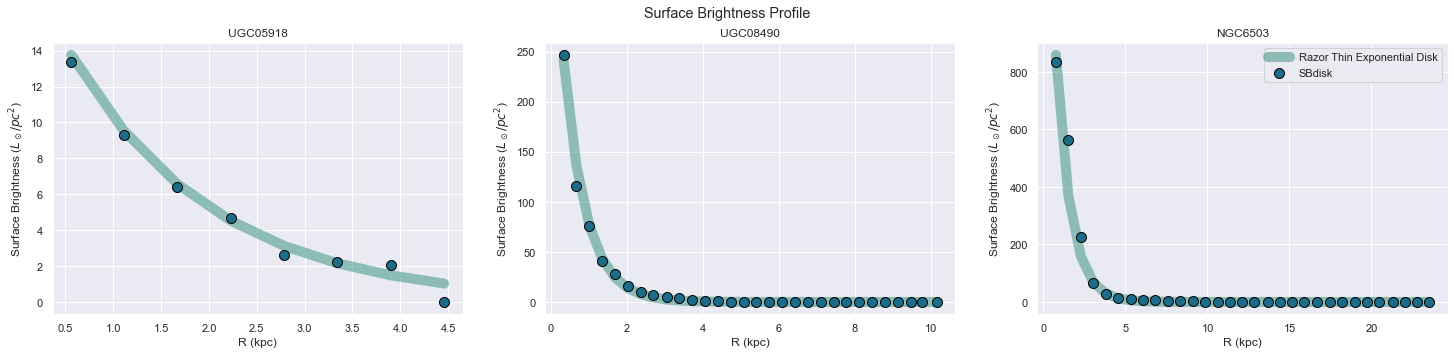

In [4]:
color = sns.color_palette("crest", 2) # It's snowing idk

disk_surfdens = [20.,430,2000]*u.Msun/u.pc**2
disk_scalelen = [1.5,0.59,.9]*u.kpc
gal = [ugc05,ugc08,ngc65]
galname = ['UGC05918','UGC08490','NGC6503']


f, axes = plt.subplots(1,3,figsize=(25,5))

for i,ax in enumerate(axes):

    R = np.array(gal[i]['R']) * u.kpc
    
    disk = potential.RazorThinExponentialDiskPotential(amp=disk_surfdens[i],hr=disk_scalelen[i])

    # Set vertical height to be 0 so surface density will be in plane of the disk. 
    surface_density = disk.surfdens(R,0) 

    ax.plot(R,surface_density,label="Razor Thin Exponential Disk",color=color[0],lw=10,alpha=.6)

    ax.scatter(R,gal[i]['SBdisk'],label="SBdisk",color=color[1],edgecolor="black",s=100,zorder=10)

    ax.set_title(galname[i])
    ax.set_xlabel('R (kpc)')
    ax.set_ylabel(r'Surface Brightness ($L_\odot / pc^2 $)')
axes[2].legend()
plt.suptitle("Surface Brightness Profile");

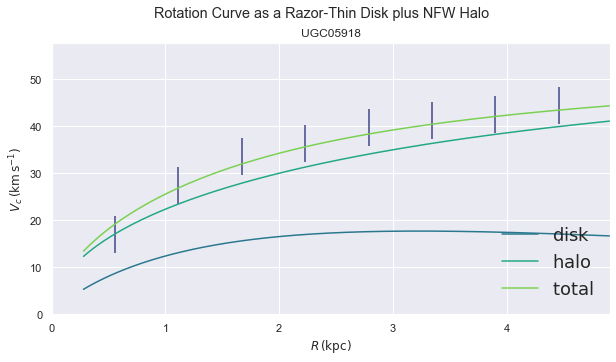

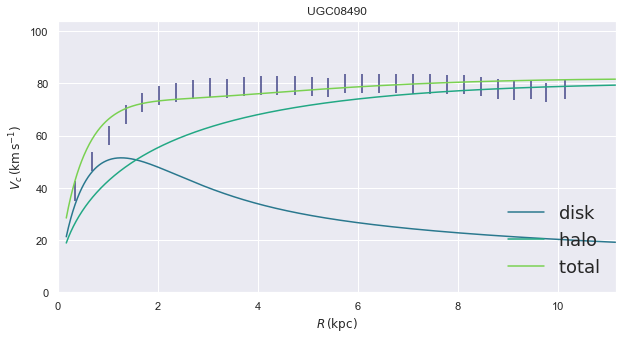

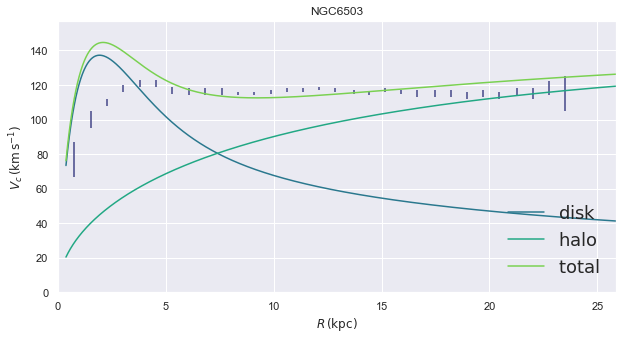

In [5]:
color = sns.color_palette("viridis", 4)

# My 'by-eye' guesses for the virial mass and concentration of the dark matter halo. 
halo_virial_mass = [5e10,1e11,1e12] * u.Msun
halo_conc = [10,21,8]

for i in range(3):
    # Set up Plot 
    plt.figure(figsize=(10,5))
    if i ==0: 
        plt.suptitle("Rotation Curve as a Razor-Thin Disk plus NFW Halo");   
    # Fit the disk by a Razor Thin Exponential Disk 
    disk = potential.RazorThinExponentialDiskPotential(amp=disk_surfdens[i],hr=disk_scalelen[i])
    # Fit the dark matter halo with an NFW potential
    halo= potential.NFWPotential(mvir=halo_virial_mass[i].to_value(1e12*u.Msun),conc=halo_conc[i],ro=8.,vo=220.)
    # Add these potentials together. 
    disk_halo = disk + halo

    plt.xlim(0.,1.1*np.max(gal[i]['R']))
    plt.ylim(0.,1.3*np.max(gal[i]['Vobs']))

    R = np.array(gal[i]['R']) * u.kpc
    R_range = [.5 * R.min(),1.1*R.max()]
    V = np.array(gal[i]['Vobs']) * u.km / u.s
    V_er = np.array(gal[i]['e_Vobs']) * u.km / u.s
    
    plt.errorbar(R.value,V.value,yerr=V_er.value,ls='none',color=color[0])
    disk.plotRotcurve(Rrange=R_range,overplot=True,label=r'$\mathrm{disk}$',color=color[1])
    halo.plotRotcurve(Rrange=R_range,overplot=True,label=r'$\mathrm{halo}$',color=color[2])
    potential.plotRotcurve(disk+halo,Rrange=R_range,overplot=True,label=r'$\mathrm{total}$',color=color[3])
    plt.title(galname[i])
    plt.ylabel(r'$V_c\,(\mathrm{km\,s}^{-1})$')
    plt.xlabel(r'$R\,(\mathrm{kpc})$')
    plt.legend(loc='lower right',frameon=False,fontsize=18.)
    


(b) What do you learn about the dark matter contribution in these
galaxies?

<font color=blue>
   
- In all cases, dark matter contributes the most at large radii though in the first case, UGC05918, dark matter is the primary contributor at all radii. The amount of dark matter present exceeds that of ordinary matter. 
- In the last case, NGC6503, fitting the surface brightness with a Razor Thin Exponential disk may have not been the best potential since the disk-model contributes excessively to the rotation curve at short radii despite the model fitting well with the data. 
- UGC08490 seems to have the highest concentration, where the concentration of dark matter seems to affect the shape of the model where the virial mass affects some of the shape but mostly the height. 
</font>

(c) The Tully-Fisher relation is a famous scaling relation for disk
galaxies that relates a galaxies asymptotic velocity $V_\infty$ to its
luminosity. It can be used, for example, to obtain distances to
galaxies, because the rotation velocity can be measured relatively
easily and the luminosity obtained from the relation can then be
combined with the observed magnitude to obtain the distance. It's also
a useful constraint on galaxy formation models. Let's use the
bulgeless SPARC galaxies to measure the Tully-Fisher relation
ourselves! To obtain a quantitative determination of $V_\infty$, we can
fit the rotation curves with a gravitational potential of the form

\begin{equation}
  \phi(r) = {v_0^2\over 2}\,\ln\left(r^2 + r_0^2\right)\,,
\end{equation}

with two free parameters, $v_0$ and $r_0$. Determine the circular
velocity as a function of radius $v_c(r)$ for this potential. What is
$V_\infty$ in terms of $v_0$ and $r_0$?

<font color=blue>
   
The centripetal acceleration is given by 
    
\begin{equation}
    a_r = \frac{d\Phi}{dr} \tag{8.14}
\end{equation}
    
\begin{equation}
    a_r = \frac{d\Phi}{dr} = \frac{d}{dr}\Big({v_0^2\over 2}\,\ln\left(r^2 + r_0^2\right)\Big) = v_o^2 \frac{r}{r^2 + r_0^2}
\end{equation}
    
    
\begin{equation}
    a_r = \frac{v_c^2}{r} \tag{8.14}
\end{equation}
    
\begin{equation}
   \frac{v_c^2}{r} = v_o^2 \frac{r}{r^2 + r_0^2}
\end{equation} 

The circular velocity as a function of radius:
    
\begin{equation}
   v_c(r) = v_o \frac{r}{\sqrt{r^2 + r_0^2}}
\end{equation} 

$V_\infty$ in terms of $v_0$ and $r_0$    
    
\begin{equation}
   v_c(r\rightarrow\infty) = v_o \frac{\infty}{\sqrt{\infty^2 + r_0^2}} = v_o
\end{equation}     
    
</font>

(d) Now fit this model to all bulgeless SPARC galaxies. Fit the model rotation velocity by minimizing $\chi^2$ defined as

\begin{equation}
  \chi^2 = \sum_i {\left[v_c(\texttt{R}_i) - \texttt{Vobs}_i\right]^2 \over \texttt{e\_Vobs}_i^2}\,,
\end{equation}

where $i$ indexes the $N$ data points for each galaxy $\{\texttt{R}_i,\texttt{Vobs}_i,\texttt{e\_Vobs}_i\}$. 


You can use scipy optimization functions for this. Compare the model fit to the observed rotation curve for the three galaxies from part (a) and do the fit for all 143 bulgeless galaxies.

In [6]:
class rotcurve:
    
    def __init__(self,galaxy,step_size):
        
        # For organization gather observed values into the class
        self.R = galaxy['R']
        self.Vobs = galaxy['Vobs']
        self.eVobs = galaxy['e_Vobs']
        self.galaxy_name = galaxy['ID'][0]
        self.L_per_area = galaxy['SBdisk']
        
        # Create grid of parameters to search through
        self.v0_range = np.arange(0,np.max(self.Vobs)+100,step_size)
        self.r0_range = np.arange(0,np.max(self.R)+50,step_size)
        
        # Meshgrid combines all possible variations of v0_range and r0_range
        self.v0_grid,self.r0_grid = np.meshgrid(self.v0_range,self.r0_range)
        self.v0_grid,self.r0_grid = self.v0_grid.flatten(),self.r0_grid.flatten()
        
        # Get chi squared value for each combination of parameters
        self.sols = self.search(galaxy,self.v0_grid,self.r0_grid)
        
        # Search for the minimum chi sq solution
        self.ind = np.where(self.sols==np.min(self.sols))
        self.r0 = self.r0_grid[self.ind]
        self.v0 = self.v0_grid[self.ind]
        self.vc = self.v_c(self.R,self.v0,self.r0)

        
    def v_c(self,r,v0,r0):
        # Equation derived above for the circular velocity
        return v0 * r / (np.sqrt(r**2+r0**2))
    
    def chisq(self,vc,vobs,e_vobs):
        # Chi squared test
        return np.sum((vc - vobs)**2 / e_vobs**2)

    def search(self,galaxy,v0_grid,r0_grid):
        sols = []
        for v0,r0 in zip(v0_grid,r0_grid):
            # Run parameter grid through model of circular velocity (vc) and calculate the chi squared (chisq) value for each combination
            sols.append(self.chisq(self.v_c(galaxy['R'],v0,r0),galaxy['Vobs'],galaxy['e_Vobs']))
        return sols


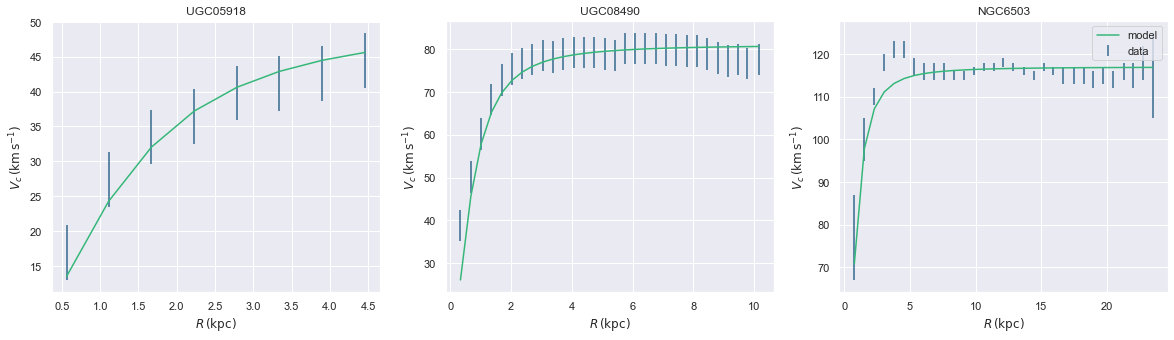

In [7]:
galaxy = [ugc05,ugc08,ngc65]

f,axes = plt.subplots(1,3,figsize=(20,5))
color = sns.color_palette("viridis", 2)
for ax,gal in zip(axes,galaxy):

    # Get class object rotcurve for each of the three galaxies
    RC = rotcurve(gal,1)
    # Plot the observed data
    ax.errorbar(RC.R,RC.Vobs,yerr=RC.eVobs,ls='none',color=color[0],label='data')
    # Plot the model
    ax.plot(RC.R,RC.vc,color=color[1],label='model')
    # Format
    ax.set_title(RC.galaxy_name)
    ax.set_ylabel(r'$V_c\,(\mathrm{km\,s}^{-1})$')
    ax.set_xlabel(r'$R\,(\mathrm{kpc})$')
axes[2].legend()

In [8]:
# Stolen from class
def bulgeless():
    raw= io.ascii.read('MassModels_Lelli2016c.mrt')
    allgals= set(raw['ID'])
    out= ()
    for gal in allgals:
        data= raw[raw['ID'] == gal]
        if np.all(np.fabs(data['Vbul']) < 1e-10):
            out= out+(gal,)
    return out
# Get the names of galaxies that contain no bulge component
nobulge_name = bulgeless()
# Get a class object for each of these
NoBulgeRC = []
for name in nobulge_name:
    galaxy = raw[raw['ID'] == name]
    NoBulgeRC.append(rotcurve(galaxy,1))

(e) Now derive the Tully-Fisher relation by computing the total luminosity of each galaxy and plotting $V_\infty$ versus the total
luminosity. Discuss what you see. 

The Tully-Fisher relation is generally well fit as $L \propto V_\infty^\alpha$; if you fit this form to your obtained relation, what value for $\alpha$ do you get (you can fit without taking errors into account). 

What $\alpha$ do you get if you only include $L > 10^{10}\,L_\odot$ galaxies? 

Which of these two determinations do you think is more accurate and why?

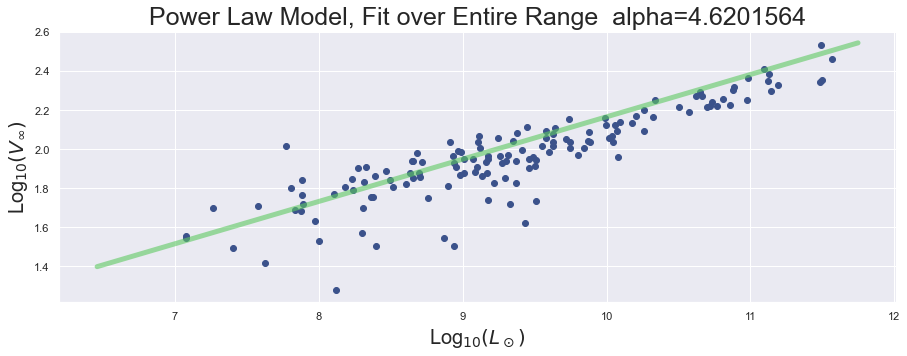

In [9]:
color = sns.color_palette("viridis", 3)
def L(RC):
    # Integrate 2 * pi * R * Surface Brightness per Area * dR to get full luminosity
    R = RC.R.to(u.pc).value # Handle Units
    return np.trapz(2*np.pi*R*RC.L_per_area,x=R)

# Get Vinf and Luminosity from the functions we've written.
Vinf = np.array([RC.v0[0] for RC in NoBulgeRC])
L = np.array([L(RC) for RC in NoBulgeRC])

def plot(Vinf,L,plot_title):
    # Power law function relation luminosity to Vinf 
    def TF(V,alpha):
        return V ** alpha

    # Fit function to data
    popt, pcov = curve_fit(TF, Vinf, L)

    # Create range over which to commute fit
    Vinf_range = np.arange(25,350)

    plt.figure(figsize=(15,5))
    # Computed Vinf and L
    plt.scatter(np.log10(L),np.log10(Vinf),color=color[0],label='Fit')
    # Power Law Fit 
    plt.plot(np.log10(TF(Vinf_range,popt[0])),np.log10(Vinf_range),color=color[2],lw=5,alpha=0.6)
    # Formatting
    plt.xlabel(r'Log$_{10} (L_\odot)$',fontsize=20)
    plt.ylabel(r'Log$_{10}(V_\infty)$',fontsize=20)
    plt.title(plot_title+f'  alpha={popt[0]:.8}',fontsize=25);
    
plot(Vinf,L,'Power Law Model, Fit over Entire Range')

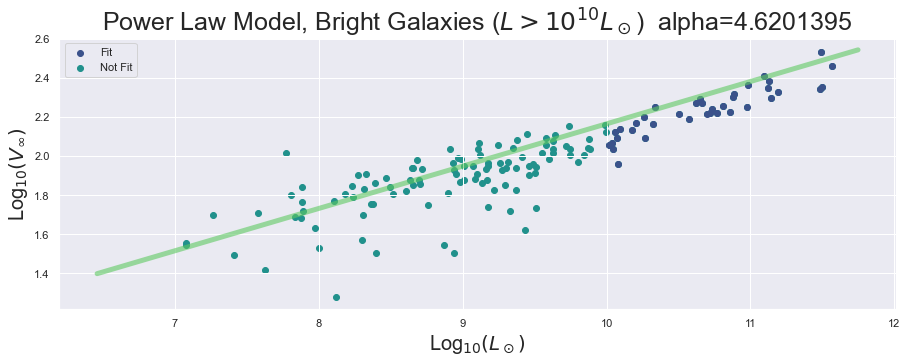

In [10]:

bright_V = Vinf[L > 1e10]
bright_L = L[L > 1e10]

plot(bright_V,bright_L,'Power Law Model, Bright Galaxies ($L > 10^{10} L_\odot$)')
plt.scatter(np.log10(L),np.log10(Vinf),color=color[1],zorder=0,label='Not Fit')
plt.legend();

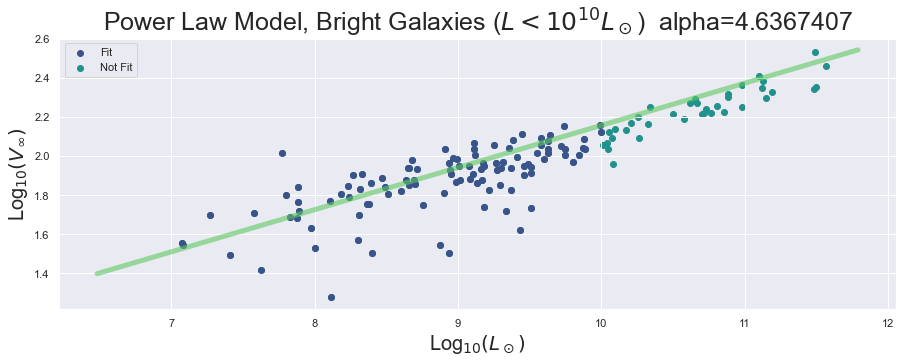

In [11]:
dim_V = Vinf[L < 1e10]
dim_L = L[L < 1e10]

plot(dim_V,dim_L,'Power Law Model, Bright Galaxies ($L < 10^{10} L_\odot$)')
plt.scatter(np.log10(L),np.log10(Vinf),color=color[1],zorder=0,label='Not Fit')
plt.legend();

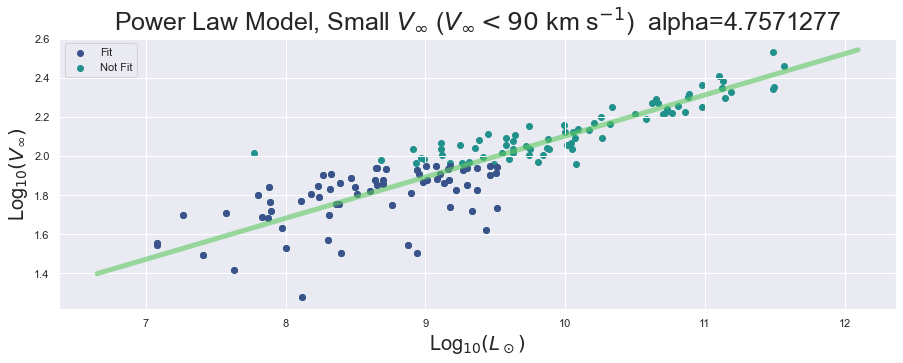

In [12]:

small_V = Vinf[Vinf < 90]
small_L = L[Vinf < 90]

plot(small_V,small_L,'Power Law Model, Small $V_\infty$ ($V_\infty < 90$ km s$^{-1}$)')
plt.scatter(np.log10(L),np.log10(Vinf),color=color[1],zorder=0,label='Not Fit')
plt.legend();

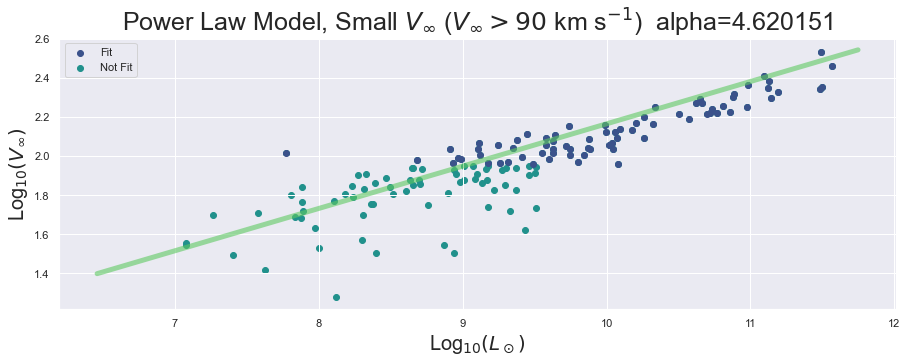

In [13]:
large_V = Vinf[Vinf > 90]
large_L = L[Vinf > 90]

plot(large_V,large_L,'Power Law Model, Small $V_\infty$ ($V_\infty > 90$ km s$^{-1}$)')
plt.scatter(np.log10(L),np.log10(Vinf),color=color[1],zorder=0,label='Not Fit')
plt.legend();

In [14]:
alphas =[4.6201564, 4.6201395, 4.6367407, 4.7571277, 4.620151] 
np.mean(alphas),np.std(alphas)

(4.650863060000001, 0.0535194945850052)

<font color=blue>
Fitting brighter galaxies $L > 10^{10}\,L_\odot$ versus the full range did not seem to change the power law exponent by much. The values were the same up to a few significant figures. I took a look at McGaugh et al., 2000 and they discussed a break in the Tully-Fisher relation around $V_c \sim 90$ km s$^{-1}$ so I played around with fitting different ranges of the data. You can see the break by eye as low luminosity (or low mass since we use $L\sim M$) galaxies have more spread. Given this you would expect fitting brighter galaxies to give a better fit since the relation is tighter. Oddly it seems to me that, by eye and without factoring in errors, fitting $V_c < 90$ gives the best fit. Regardless the power law slope is given by $4.65\pm 0.05$ so the variation between fits is not extremely high. If it is true, that bright galaxies give the best fit, that would be quite lucky! As it would enable distance measurements at farther distances which does seem to be the case given the cosmic distance ladder. 
<\font>    

### Problem 2: The zero-velocity curve.

When we looked at orbits in disk galaxies, we discussed the
zero-velocity curve: the curve in the meridional plane $(R,z)$ where
$v_R = v_z = 0$. Let's explore this important curve further!



(a) For the example orbit in Chapter 10.1, we showed
the zero-velocity curve as a constant energy contour, but we could
also explicitly compute $z$ as a function of $(R,E,L_z)$ on the
zero-velocity curve by demanding that $v_R = v_z = 0$. Do this for the
first example orbit in Chapter 10.1 and compare to the zero-velocity
curve that you get from the contouring method. (note that you may not
be able to solve for $z$ analytically and might have to resort to
numerical methods)

In [15]:
def plot_potential(E,Lz,pot):
    # Stolen from you (:
    levels = np.linspace(-1.25,0.,11)
    cntrcolors = ['k' for l in levels]
    cntrcolors[np.arange(len(levels))\
       [np.fabs(levels-E) < 0.01][0]]= '#ff7f0e'
    potential.plotPotentials(pot,
                     rmin=0.3,rmax=1.05,
                     zmin=-0.3,zmax=0.3,
                     nrs=101,nzs=101,
                     justcontours=True,
                     levels=levels,
                     cntrcolors=cntrcolors,
                     effective=True,
                     Lz=Lz)

/home/bethany/anaconda3/lib/python3.7/site-packages/galpy/util/bovy_plot.py:644: UserWarning: The following kwargs were not used by contour: 'aspect'
  linestyles=cntrls,origin=origin)



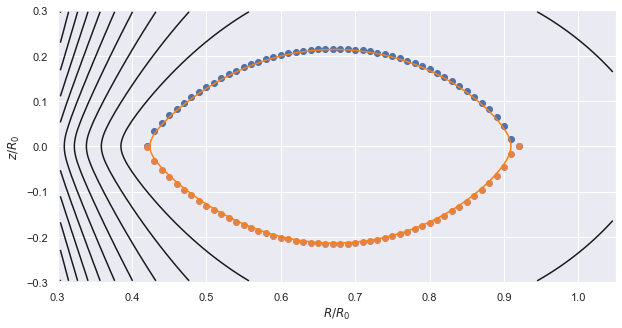

In [16]:
R_range=np.arange(0.42,0.93,0.01)
guess = np.repeat(0.1,len(R_range))

def effPot(z,R=R_range):
    # When does E = effPot ? 
    # effPot is equation 10.8
    pot = potential.MWPotential2014
    E = -1.25
    Lz = 0.60
    Pot = potential.evaluatePotentials(pot,R,z)
    return Pot + (Lz/R)**2./2 - E

# Use FindRoot method to get a value for z that will make E equal the effective potential for a range of R values. 
Zs = root(effPot,guess)

# Plot the contour method
plot_potential(E=-1.25,Lz=0.60,pot=potential.MWPotential2014)

# Plot my method
plt.scatter(R_range,Zs.x)

# Flip it and reverse it 
plt.scatter(R_range,-Zs.x)

# Make the plot bigger
f = plt.gcf()
f.set_size_inches(10, 5)

(b) In the notes, we discussed how orbits touch the zero-velocity curve at four points, but there are orbits at a given $(E,L_z)$ that only touch the zero-velocity curve at two points. 

These orbits are called the thin tubes, because in 3D they look like a tube (that's thin!). 

- Devise an algorithm to find this orbit for a given $(E,L_z)$ and apply it to the $(E,L_z)$ of the example orbit in (a) 
- [there are various, qualitatively different ways to do this; explain why your algorithm works in general]. 
- Show the orbit in $(R,z)$ and $(x,y,z)$
- Discuss what you think is interesting about this orbit.

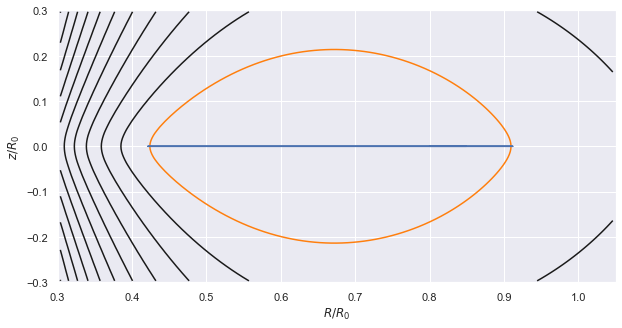

In [17]:
R, E, Lz = 0.8, -1.25, 0.6
pot=potential.MWPotential2014

deltaE = 2.*(E-potential.evaluatePotentials(pot,R,0.) - (Lz/R)**2./2)

vR = np.sqrt(deltaE)

vT = Lz/R

z = 0

vZ = np.sqrt(2.*(E-potential.evaluatePotentials(pot,R,0.) -(Lz/R)**2./2.-vR**2./2))

phi = 0

orbit = Orbit([R,vR,vT,z,vZ,phi])

ts = np.linspace(0.,100.,2001)
orbit.integrate(ts, pot)


# Plot the contour method
plot_potential(E,Lz,pot=pot)

# Plot the orbit
orbit.plot(overplot=True)

# Make the plot bigger
f = plt.gcf()
f.set_size_inches(10, 5)

In [18]:
x,y,z = [],[],[]

for t in ts:
    x.append(orbit(t).x())
    y.append(orbit(t).y())
    z.append(orbit(t).z())
plt.clf()

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'y')

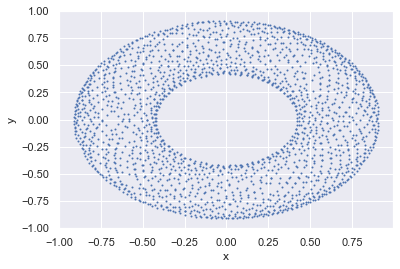

In [28]:
#Z is 0!

plt.scatter(x,y,s=1)
plt.xlabel('x')
plt.ylabel('y')

<font color=blue>  
To find the orbit that just touches two points of the zero-velocity curve, I set $vR = \sqrt{\Delta E}$ where $\Delta E = 2(E-\Phi(z,R) - \frac{1}{2}(Lz/R)^2)$. This essentially amounts to allowing the other velocity component, vZ to be 0, that way all the energy gets put into vR, maximizing the amount it can be. 
  
That's pretty much it, I don't know if I should have done more of an algorithm than that. One of the things that I noticed when testing this out on other potentials is that if $\Delta E$ is negative this can be kind of an issue since then vR is unreal. In the case of this orbit, using something basic like a Kepler potential gives a slightly negative $\Delta E$ but increasing E a bit takes care of this problem. This solution may not work for every single orbit but I do think it will work in general. The original method I played around with down below in the graveyard was to treat it like an optimization problem. I let vR vary from 0 to $\Delta E$ and then took the points where the orbit came close to the zero-velocity curve and tried to minimize $\frac{1}{N}\sum_i |z_i|$. I thought this would work since clearly the orbit with two points is the one that touches the inner and outer corner of the "eye" like curve which sits around z = 0. I quickly realized though that the answer just ended up being $vR = \sqrt{\Delta E}$ every time. 

What's interesting about these "tubes" is in x,y,z they look like a flat torus. These orbits completely avoid the center while oscillating from -1 to 1 in either direction. 
    
</font>

### Graveyard 

At first I think I misinterpretted question 2 and wrote a ton of code thinking I was supposed to find the four z points at the corner and now I'm attached so I didn't want to delete it.

In [20]:
class zero_orbit:
    
    def __init__(self,R,E,Lz,pot=potential.MWPotential2014):
        
        self.potential = pot
        
        self.R = R
        
        self.E = E
        
        self.Lz = Lz
        
        orbit, time_points = self.compute_zero_velocity_z()
        
        self.orbit = orbit
        
        self.zero_t = np.array(time_points)[:,0]
        
        self.zero_d = np.array(time_points)[:,1]
        
        self.zero_r,self.zero_z = self.rZ(orbit,time_points)
        
        self.optimized_value = np.min(np.sum(self.zero_z)/len(self.zero_z))
        
        self.deltaE = 2.*(E-potential.evaluatePotentials(pot,R,0.) - (Lz/R)**2./2)
        

    def compute_zero_velocity_z(self,vR=0):
        vT = self.Lz / self.R
        vZ = np.sqrt(2.*(self.E-potential.evaluatePotentials(self.potential,self.R,0.) -(self.Lz/self.R)**2./2.-vR**2./2))
        z = 0
        phi = 0

        # How close to get to the corner is acceptable
        tol = 0.05 # 10 ???

        # Calculate the orbit, I took physical units off for now since I want things to be on the same scale 
        orbit = Orbit([self.R,vR,vT,z,vZ,phi])
        ts = np.linspace(0.,100.,2001)
        orbit.integrate(ts, self.potential)

        # On the zero-velocity curve when vR = vZ = 0
        zero_velocity_curve_points = []
        for t in ts :
            vr = orbit(t).vR()
            vz = orbit(t).vz()
                          
            # How close are we to the distance velocity curve
            distance_to_curve = np.sqrt(vr**2 + vz**2)

            # If we're close to 0 save the time step and the distance
            if np.isclose(distance_to_curve, 0, atol = tol):
                zero_velocity_curve_points.append([t, distance_to_curve])

        return orbit, zero_velocity_curve_points
    
    def rZ(self,orbit,time_points):
        # At times in the orbit where the sqrt of vr^2 vz^2 is closest to zero, collect the R and Z. 
        rs,zs = [],[]
        for t in time_points :
            rs.append(orbit(t[0]).R())#.value)
            zs.append(orbit(t[0]).z())#.value)
            
        return np.array(rs),np.array(zs)
    
    def plot_potential(self):
        levels = np.linspace(-1.25,0.,11)
        cntrcolors = ['k' for l in levels]
        cntrcolors[np.arange(len(levels))\
           [np.fabs(levels-self.E) < 0.01][0]]= '#ff7f0e'
        potential.plotPotentials(self.potential,
                         rmin=0.3,rmax=1.05,
                         zmin=-0.3,zmax=0.3,
                         nrs=101,nzs=101,
                         justcontours=True,
                         levels=levels,
                         cntrcolors=cntrcolors,
                         effective=True,
                         Lz=self.Lz)

    def optimize(self):
            
        deltaE = 2.*(self.E-potential.evaluatePotentials(self.potential,self.R,0.) - (self.Lz/self.R)**2./2)
        
        print(deltaE)
        
        vR_range = np.arange(0,np.sqrt(self.deltaE),0.01)
        
        print(len(vR_range))
        
        self.optimized_vals = []
        for vR in vR_range:
            vT = self.Lz/self.R
            vZ = np.sqrt(2.*(self.E-potential.evaluatePotentials(self.potential,self.R,0.) -(self.Lz/self.R)**2./2.-vR**2./2))
            z = 0
            phi = 0
            
            orbit, time_points = self.compute_zero_velocity_z(vR)

            zero_r,zero_z = self.rZ(orbit,time_points)

            optimized_value = np.min(np.sum(np.abs(zero_z))/len(zero_z))
            
            print(optimized_value)
            
            self.optimized_vals.append(optimized_value)

            
                          



/home/bethany/anaconda3/lib/python3.7/site-packages/galpy/util/bovy_plot.py:644: UserWarning: The following kwargs were not used by contour: 'aspect'
  linestyles=cntrls,origin=origin)



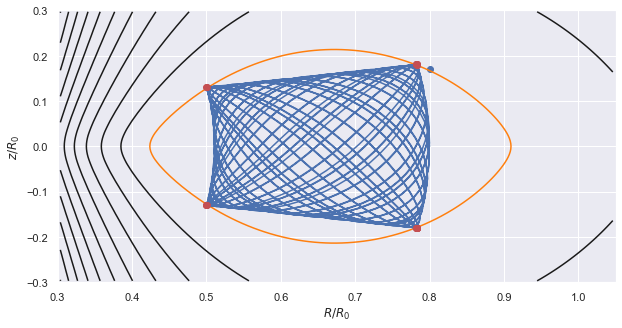

In [21]:
zOrb = zero_orbit(R = 0.8, E = -1.25, Lz = 0.60)

zOrb.plot_potential()
zOrb.orbit.plot(overplot=True,use_physical=False)
plt.scatter(zOrb.zero_r,zOrb.zero_z, c='r', zorder=10)
plt.scatter(0.8,0.16966632)
f = plt.gcf()
f.set_size_inches(10, 5)

In [22]:
vR = np.sqrt(zOrb.deltaE)

orbit, time_points = zOrb.compute_zero_velocity_z(vR)

/home/bethany/anaconda3/lib/python3.7/site-packages/galpy/util/bovy_plot.py:644: UserWarning: The following kwargs were not used by contour: 'aspect'
  linestyles=cntrls,origin=origin)



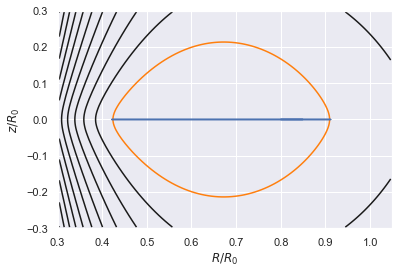

In [23]:
zOrb.plot_potential()
orbit.plot(overplot=True,use_physical=False)

/home/bethany/anaconda3/lib/python3.7/site-packages/galpy/util/bovy_plot.py:644: UserWarning: The following kwargs were not used by contour: 'aspect'
  linestyles=cntrls,origin=origin)



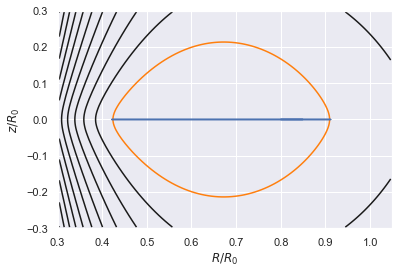

In [24]:
zOrb.plot_potential()
orbit.plot(overplot=True,use_physical=False)

In [25]:
np.sqrt(E)

/home/bethany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.



nan

In [26]:
vR_range = np.arange(0,np.sqrt(E))

nOrb = zero_orbit(R = 0.8, E = -1.25, Lz = 0.60,vR=0.2)
nOrb.optimized_value

/home/bethany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.



ValueError: arange: cannot compute length

In [ ]:
zOrb = zero_orbit(R = 0.8, E = -1.25, Lz = 0.60)

zOrb.plot_potential()
zOrb.orbit.plot(overplot=True,use_physical=False)
plt.scatter(zOrb.zero_r,zOrb.zero_z, c='r', zorder=10)

f = plt.gcf()
f.set_size_inches(10, 5)

In [ ]:
plt.clf()
%matplotlib inline

R, E, Lz = 0.8, -.25, 0.6

pot=potential.KeplerPotential()

deltaE = 2.*(E-potential.evaluatePotentials(pot,R,0.) - (Lz/R)**2./2)

vR = np.sqrt(np.abs(deltaE))

vT = Lz/R

z = 0

vZ = np.sqrt(2.*(E-potential.evaluatePotentials(pot,R,0.) -(Lz/R)**2./2.-vR**2./2))

phi = 0
print([R,vR,vT,z,vZ,phi])
orbit = Orbit([R,vR,vT,z,vZ,phi])

ts = np.linspace(0.,100.,1001)
orbit.integrate(ts, pot)


# Plot the contour method
#plot_potential(E,Lz,pot=pot)

# Plot the orbit
orbit.plot(overplot=True)

# Make the plot bigger
f = plt.gcf()
f.set_size_inches(10, 5)
ax = plt.gca()
ax.set_ylim(-1,1)
ax.set_xlim(1,100)